In [13]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

### Utils
necessary for image viewing

In [3]:
def image_stack(img_array, scale, labels=[]):
    """
    Stack a list of images horizontally and add labels.

    Args:
    - img_array (list of lists or list of ndarrays): A list of images to stack. It can be a list of lists
      for stacking multiple rows of images.
    - scale (float): The scaling factor for resizing the images.
    - labels (list of lists, optional): Labels for the images. It should have the same structure as img_array.

    Returns:
    - ndarray: The horizontally stacked and labeled image.

    Note:
    - The input images should be in the form of NumPy ndarrays.
    - If labels are provided, they are displayed above each image in the stack.
    """

    rows = len(img_array)
    cols = len(img_array[0])

    width = img_array[0][0].shape[1]
    height = img_array[0][0].shape[0]

    if isinstance(img_array[0], list):
        for x in range(0, rows):
            for y in range(0, cols):
                img_array[x][y] = cv2.resize(img_array[x][y], (0, 0), None, scale, scale)
                if len(img_array[x][y].shape) == 2:
                    img_array[x][y] = cv2.cvtColor(img_array[x][y], cv2.COLOR_GRAY2BGR)
        img_blank = np.zeros((height, width, 3), np.uint8)
        hor = [img_blank] * rows
        hor_con = [img_blank] * rows
        for x in range(0, rows):
            hor[x] = np.hstack(img_array[x])
            hor_con[x] = np.concatenate(img_array[x])
        ver = np.vstack(hor)
    else:
        for x in range(rows):
            img_array[x] = cv2.resize(img_array[x], (0, 0), None, scale, scale)
            if len(img_array[x].shape) == 2:
                img_array[x] = cv2.cvtColor(img_array[x], cv2.COLOR_GRAY2BGR)
        hor = np.hstack(img_array)
        ver = hor

    if labels:
        each_img_width = int(ver.shape[1] / cols)
        each_img_height = int(ver.shape[0] / rows)
        for d in range(rows):
            for c in range(cols):
                cv2.rectangle(ver, (c * each_img_width, each_img_height * d),
                              (c * each_img_width + len(labels[d][c]) * 13 + 27, 30 + each_img_height * d), (255, 255, 255),
                              cv2.FILLED)
                cv2.putText(ver, labels[d][c], (c * each_img_width + 10, each_img_height * d), cv2.FONT_HERSHEY_SIMPLEX,
                            0.7, (255, 0, 255), 2)
    return ver


### Document Skew Correction

In [9]:
def otsu_thresh(image):
    """
    Apply Otsu's thresholding to an input image.

    Args:
    - image (ndarray): The input grayscale image.

    Returns:
    - int: The computed Otsu threshold value.
    - ndarray: The thresholded binary image.
    """
    # Compute the histogram of the input image
    hist, bin_edges = np.histogram(image, bins=256)

    # Normalize the histogram
    hist = np.divide(hist.ravel(), hist.max())

    # Compute bin centers
    bin_mids = (bin_edges[:-1] + bin_edges[1:]) / 2.

    # Calculate cumulative weights and means
    weight1 = np.cumsum(hist)
    weight2 = np.cumsum(hist[::-1])[::-1]
    mean1 = np.cumsum(hist * bin_mids) / weight1
    mean2 = (np.cumsum((hist * bin_mids)[::-1]) / weight2[::-1])[::-1]

    # Compute inter-class variance
    inter_class_variance = weight1[:-1] * weight2[1:] * (mean1[:-1] - mean2[1:]) ** 2

    # Find the index of the maximum inter-class variance
    index_of_max_val = np.argmax(inter_class_variance)

    # Determine the threshold value
    threshold = bin_mids[:-1][index_of_max_val]

    # Slightly adjust the threshold for practical use
    threshold = int(1.1 * threshold)

    if len(image.shape) != 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Otsu's thresholding to the image
    image_result = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    return threshold, image_result

In [33]:
def preprocess_img(image, kernel_size=9, skip_dilatation=False):
    """
    Preprocess an image for better results in OCR by applying Gaussian blur, adaptive thresholding, and dilation.

    Args:
    - img (ndarray): The input image to be preprocessed.
    - kernel_size (int, optional): The size of the Gaussian blur kernel.
    - skip_dilatation (bool, optional): Whether to skip the dilation step.

    Returns:
    - ndarray: The preprocessed image.
    """
    if len(image.shape) != 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to reduce noise
    noise_reduced_img = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

    # Apply adaptive thresholding to binarize the image
    binarized_img = cv2.adaptiveThreshold(noise_reduced_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # Invert colors to emphasize gridlines (non-zero pixels)
    inverted_img = cv2.bitwise_not(binarized_img, binarized_img)

    if not skip_dilatation:
        # Apply dilation to make gridlines more pronounced
        kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], np.uint8)
        return cv2.dilate(inverted_img, kernel)

    return inverted_img


In [37]:
def skew_correct(image):
    """
    Correct skew in an image.

    Args:
    - image (ndarray): The input image (grayscale and inverted).

    Returns:
    - ndarray: The deskewed image.
    """
    # Find the coordinates of all pixel values greater than zero
    coords = np.column_stack(np.where(image > 0))

    # Compute the angle of the minimum area rectangle that contains the coordinates
    angle = cv2.minAreaRect(coords)[-1]

    # Adjust the angle to the range (-45, 45) degrees
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle

    # Get image dimensions
    (h, w) = image.shape[:2]

    # Calculate the rotation center
    center = (w // 2, h // 2)

    # Create a rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Rotate the image to deskew it
    rotated_img = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    return rotated_img


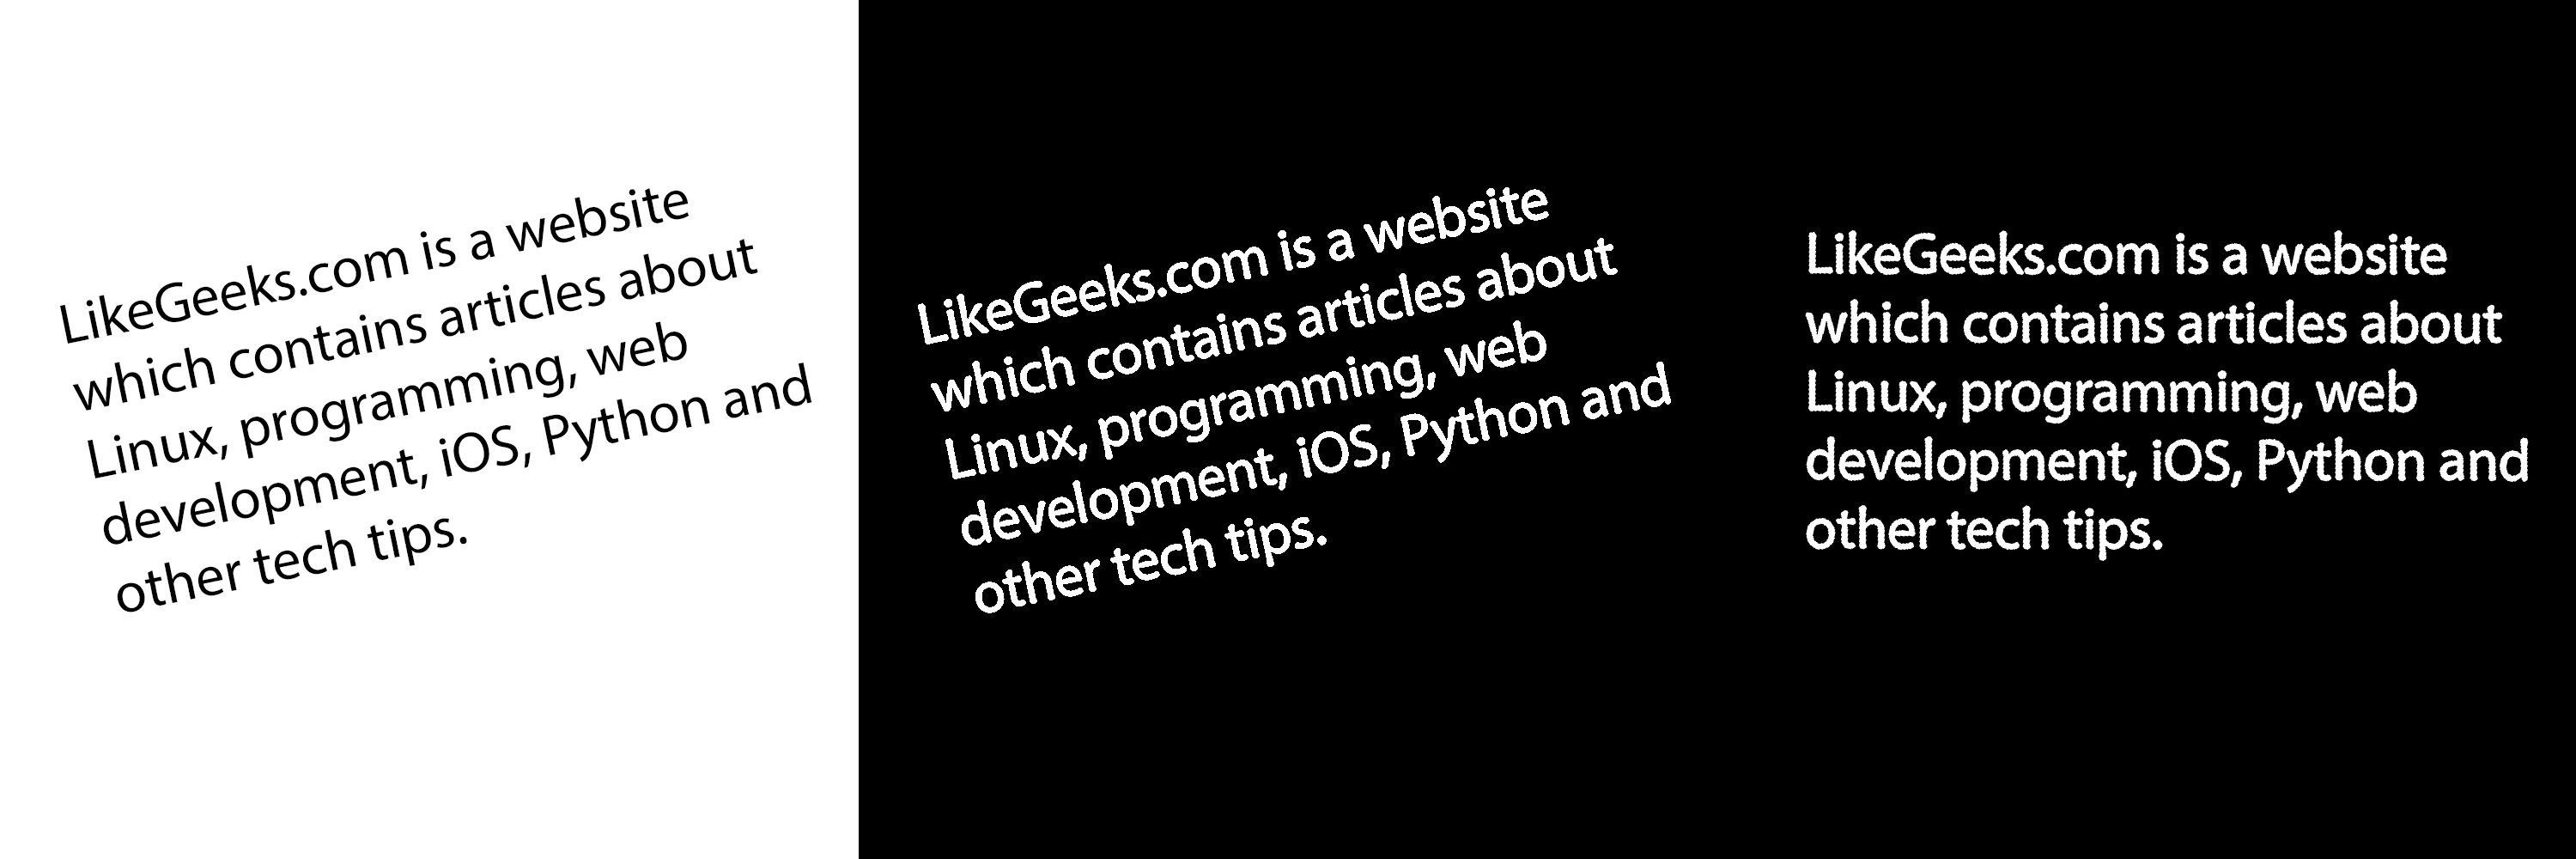

In [95]:
image = cv2.imread("/content/Skewed-text-image.png")
preprocessed_image = preprocess_img(image)
deskwed_image = skew_correct(preprocessed_image)
img_array = [image, preprocessed_image, deskwed_image]
cv2_imshow(image_stack(img_array, 1))

### Segmentation

In [90]:
def line_segment(image, width = 500):
    """
    Perform line segmentation on a preprocessed, inverted, and deskewed image.

    Args:
    - image (ndarray): Preprocessed, Skew Corrected, Binarized input image.
    - width (int, optional): The desired width for the output histogram image.

    Returns:
    - list: Lists of line starting and finishing positions.
    """
    # Calculate horizontal projection
    proj = np.sum(image, 1)

    # Create an output image with the same height as the text and the specified width
    m = np.max(proj)
    histogram_result = np.zeros((proj.shape[0], width))

    # Draw a line for each row in histogram
    for row in range(image.shape[0]):
        cv2.line(histogram_result, (0, row), (int(proj[row] * width / m), row), (255, 255, 255), 1)

    j = 0
    count = 0
    line_start = []
    line_finish = []
    for i in proj:
        if i != 0 and j == 0:
            line_start.append(count)
        elif i == 0 and j != 0:
            line_finish.append(count)
        j = i
        count = count + 1
    count = 0

    view_result(image.copy(), line_start, line_finish)

    return line_start, line_finish


def view_result(image, line_start, line_finish):
    """
    Visualize the line segmentation result.

    Args:
    - image (ndarray): The original image.
    - line_start (list): Lists of line starting positions.
    - line_finish (list): Lists of line finishing positions.
    """
    col = image.shape[1]

    for count in range(len(line_start)):
        cv2.line(image, (0, line_start[count]), (col - 1, line_start[count]), (255, 255, 255), 1)
        cv2.line(image, (0, line_finish[count]), (col - 1, line_finish[count]), (255, 255, 255), 1)

    image = cv2.resize(image, (500, 500))
    cv2_imshow(image)


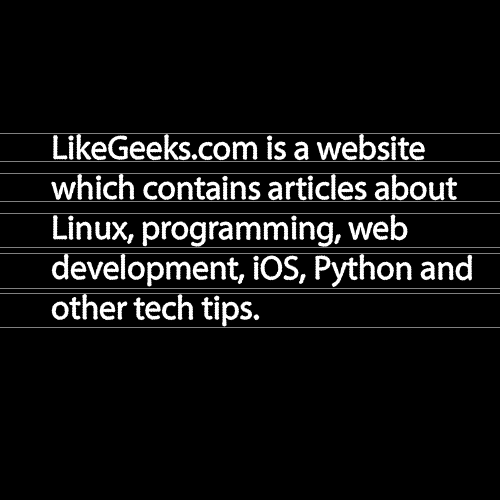

In [96]:
line_start, line_end = line_segment(deskwed_image)

In [131]:
def character_segment(image, line_start, line_finish, threshold_factor = 20):
    """
    Segment characters within lines of an image.

    Args:
    - image (ndarray): Preprocessed, Skew Corrected, Binarized input image.
    - line_start, line_finish : points obtained from line segmentation
    - threshold: default is 20,
    if you experience under-segmentation(not all characters separated), increase the value
    otherwise (under-segmentation), decrease it

    Note:
    - This function assumes that you have preprocessed the image and obtained line starting and finishing positions
      using the `lineStart` and `lineFinish` variables.

    Returns:
    - None: This function displays the image with character boundaries drawn.
    """
    count_line = 0
    word_start = []
    word_finish = []
    lines = len(line_start)
    col = image.shape[1]

    for x in range(lines):
        img_line = image[line_start[count_line]:line_finish[count_line], 0:col-1]

        # Calculate vertical projection
        proj = np.sum(img_line, 0)


        start_temp = []
        finish_temp = []
        count_char = 0
        threshold = np.max(proj)
        if (0 < threshold_factor < 100):
            threshold = threshold // threshold_factor
        for i in proj:
            if i > threshold and proj[count_char-1] <= threshold:
                start_temp.append(count_char)
            elif i <= threshold and proj[count_char-1] > threshold:
                finish_temp.append(count_char)
            count_char = count_char + 1
        word_start.append(start_temp)
        word_finish.append(finish_temp)
        count_line = count_line + 1

    for x in range(lines):
        for y in range(len(word_start[x])):
            cv2.rectangle(image, (word_start[x][y], line_start[x]), (word_finish[x][y], line_finish[x]), (255, 255, 255), 1)

    cv2_imshow(image)



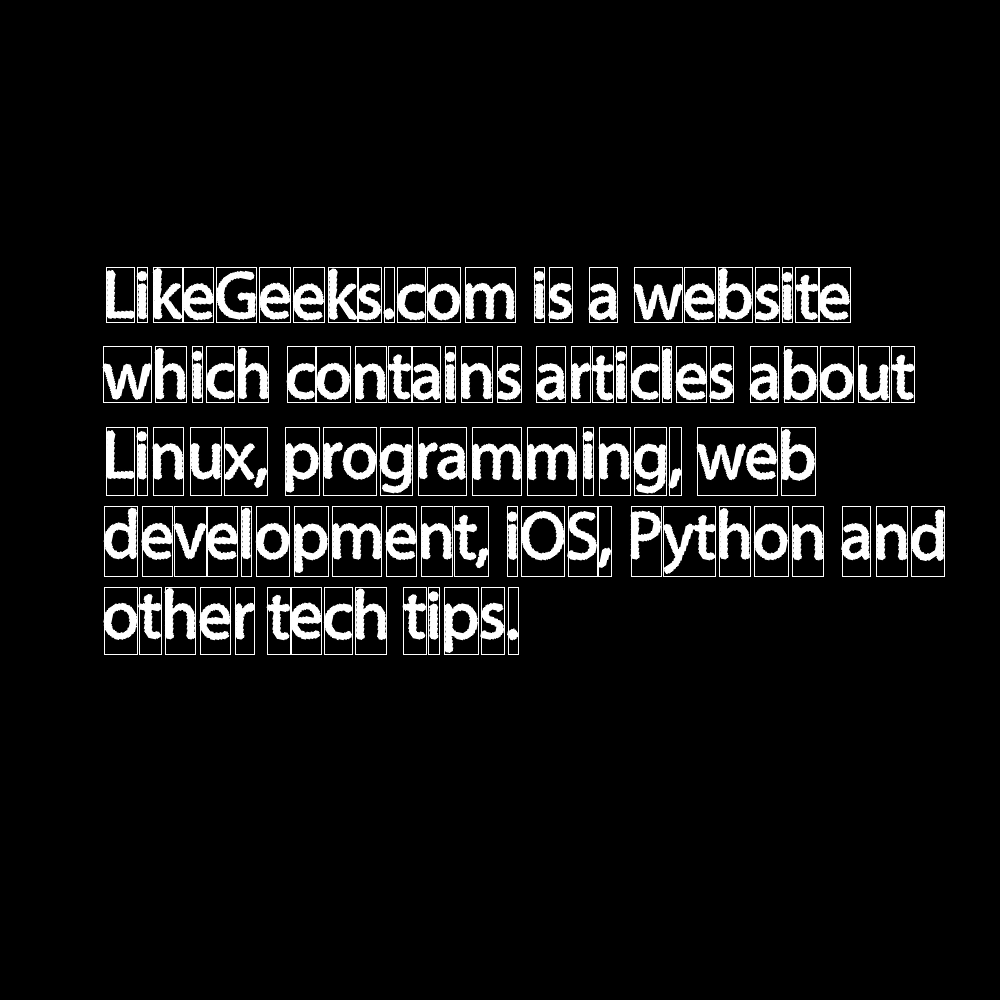

In [132]:
character_segment(deskwed_image.copy(), line_start, line_end)